# A tutorial for InSAR data in CSI


In [1]:
#------------------------------------------------------------------
#------------------------------------------------------------------
# 
#            Plotting, Downsampling and computing covariance 
#                           for InSAR data
# 
#------------------------------------------------------------------
#------------------------------------------------------------------

# Import personal libraries
import csi.TriangularPatches as triangleflt
import csi.insar as insar
import csi.imagedownsampling as imdown
import csi.imagecovariance as imcov

# Imports 
import numpy as np
import os, copy

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as path

# Nice colors
from cmcrameri import cm

# F*** off warnings
import warnings
warnings.simplefilter("ignore") 

# Some styling changes
from pylab import rcParams
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.labelsize'] = 'x-large'
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'

# Reference
lon0=33.0
lat0=40.8

## Create a fault object

In [2]:
# Import fault
intrace = os.path.join(os.getcwd(),'DataAndModels/NAF.xy')
ingeomt = os.path.join(os.getcwd(),'DataAndModels/NAF.triangles')

# Create the fault
naf = triangleflt('North Anatolian Fault', lon0=lon0, lat0=lat0)

# Read the trace of the fault (mostly for plotting purposes)
naf.file2trace(intrace, header=0)

# Read the triangular mesh of the fault
# This one has been built using PyDistMesh, a Python implementation of DistMesh (Persson, 2004)
naf.readGocadPatches(ingeomt)

# For later plotting
naf.color='r'
naf.linewidth=2

---------------------------------
---------------------------------
Initializing fault North Anatolian Fault


## Read and plot the InSAR data

In [3]:
# For simplicity, we directly use a binary file. Some readers are available in CSI, but since there is an infinite 
# number of ways to store InSAR data (almost...), it is better to use a custom reader. Build your own and make it 
# to binary format.
# If you feel like contributing, be my guest and implement your own in CSI.
shape = (2200, 2068)

# Read the velocity map
velocity = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFvel.flt'), 'f')
uncertainty = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFerr.flt'), 'f')

# Read the rms map
rms = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFrms.flt'), 'f')
nifg = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFnifg.flt'), 'f')

# Read lon lat
lon = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFlon.flt'), 'f')
lat = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFlat.flt'), 'f')

# Line-of-sight
los = np.fromfile(os.path.join(os.getcwd(),'DataAndModels/NAFlos.flt'), 'f').reshape((shape[0], shape[1]*2))
inc = los[:,:shape[1]]
azi = los[:,shape[1]:]

# Mask to clean things up
velocity[rms>3.] = np.nan
velocity[velocity==0.] = np.nan
velocity[nifg<500] = np.nan
velocity[uncertainty>0.5] = np.nan


In [4]:
# Make a velocity object
rate = insar('Rate map T167', lon0=lon0, lat0=lat0)

# Read the binary data into the object
# Note that these arrays could be files
rate.read_from_binary(velocity, lon, lat, err=None, 
                      remove_nan=True, remove_zeros=True, 
                      incidence=inc.flatten(), azimuth=azi.flatten())

# Here, we remove the NaNs
rate.checkNaNs()

# Here, we find the points that are more that 60 km away from the fault
d = rate.getDistance2Faults(naf)

# We set these to NaNs
rate.vel[d>60.] = np.nan
rate.vel[d<1.] = np.nan

# And we remove them
rate.checkNaNs()

# Show me
# The shaded topo argument will only work if 1. cartopy fixes the way they download the data, or 2. if you have downloaded and unzipped the tiles yourself and 
# pasted these in the .local/share/cartopy/SRTM/SRTMGL1 folder. If you want, you can comment this argument.
rate.plot(plotType='scatter', norm=[-15, 15], figsize=(15, 15), 
          drawCoastlines=True, faults=naf, seacolor='lightblue', cmap=cm.roma, 
          shadedtopo={'source': 'srtm', 'smooth': 10, 'alpha': 0.1})

# The plotType argument can be 'scatter', 'decimate' or 'flat'.
# The 'scatter' option will plot the data as a scatter plot, with the color of the points representing the velocity.
# The 'decimate' option will look for the decimation pattern in the insar object (see below) and plot the data as squares over the decimated grid.
# The 'flat' option will plot the data as a contourf image, using the nx and ny arguments to define the number of points in the x and y axis. If there is no NaNs, the plot is not nice as it interpolates.

---------------------------------
---------------------------------
Initialize InSAR data set Rate map T167
/Users/romainjolivet/.local/share/cartopy/SRTM/SRTMGL1/N40E032.hgt <class 'pathlib._local.PosixPath'> N40E032.hgt


UnboundLocalError: cannot access local variable 'filename' where it is not associated with a value

<Figure size 1500x1500 with 2 Axes>

Now this map is not very pretty but can be customized, first with the arguments of the plot method but also using the figure object directly. For instance, we can change the colorbar position, size and its label

Carefull: there is no NaNs, the interpolation might be a whole load of garbage...


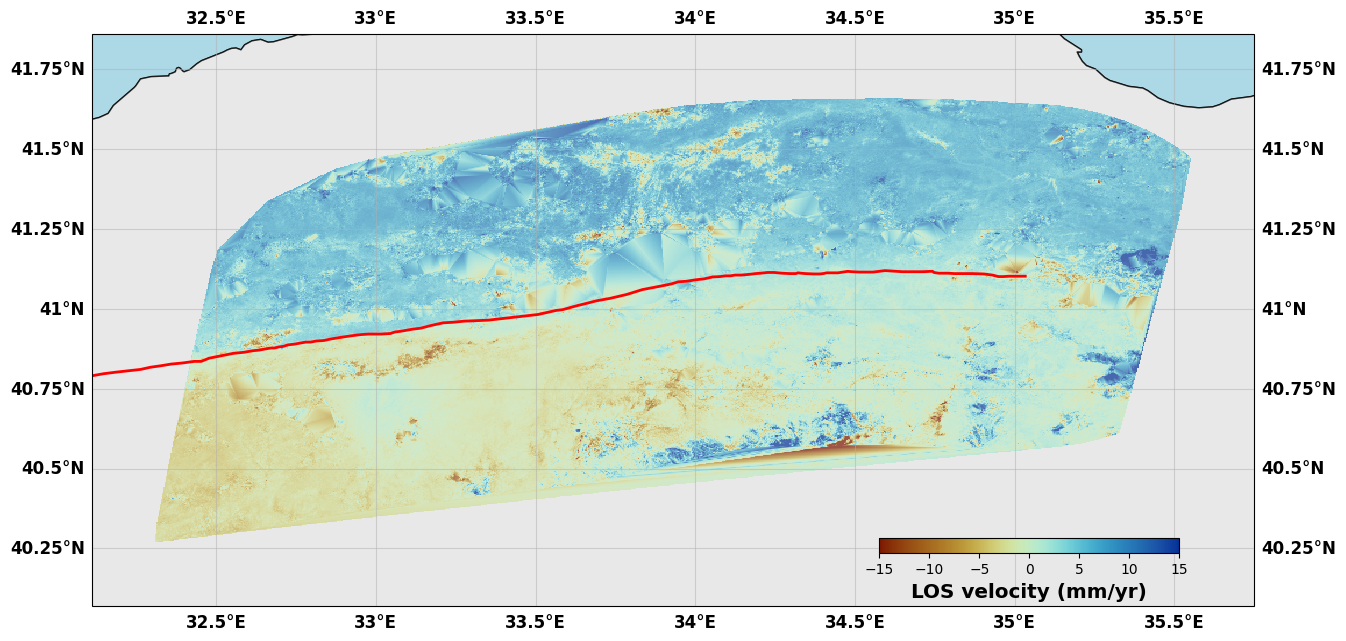

In [6]:
rate.plot(plotType='flat', norm=[-15, 15], figsize=(15, 15), alpha=0.7, 
          drawCoastlines=True, faults=naf, seacolor='lightblue', cmap=cm.roma,
          cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')
          #shadedtopo={'source': 'srtm', 'smooth': 10, 'alpha': 0.1})

---------------------------------
---------------------------------
Initialize InSAR data set Rate map T167


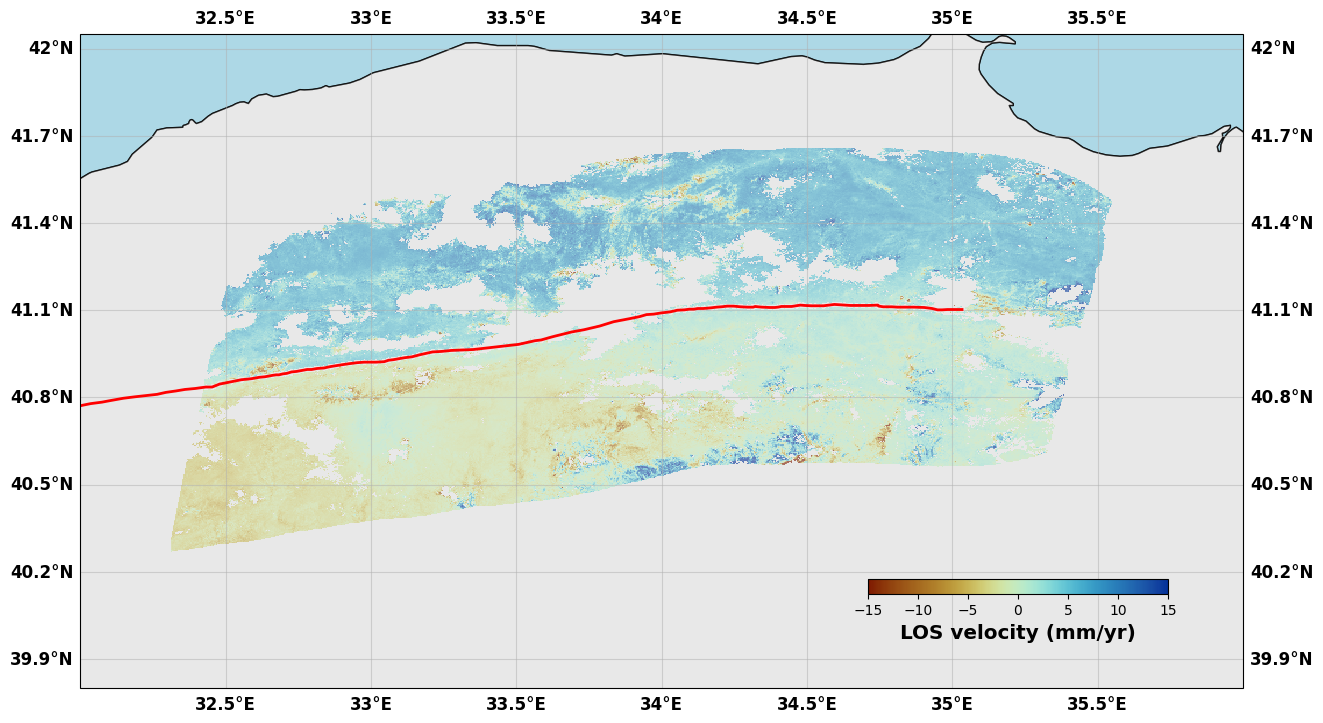

In [7]:
# You can see there is some weird color patches here and there, corresponding to the interpolation used for the flat option. 
# This is why we use the scatter option for the first plot. Now, if we want to use the flat option, we can just keep the NaNs and interpolate.

# Make a velocity object
rate = insar('Rate map T167', lon0=lon0, lat0=lat0)

# Read the binary data into the object
# Note that these arrays could be files
rate.read_from_binary(velocity, lon, lat, err=None, 
                      remove_nan=False, remove_zeros=False, 
                      incidence=inc.flatten(), azimuth=azi.flatten())

# Here, we find the points that are more that 60 km away from the fault
d = rate.getDistance2Faults(naf)

# We set these to NaNs
rate.vel[d>60.] = np.nan
rate.vel[d<1.] = np.nan

# Show me
# Since we have not removed the NaNs, the image might be larger than the zone of the interest, so we provide the box argument to zoom in.
rate.plot(plotType='flat',  # Plot style
          norm=[-15, 15],   # Colorbar limits
          figsize=(15, 15), # Figure size
          alpha=0.6,        # Transparency
          box=[32., 36., 39.80, 42.05], # Map extent
          drawCoastlines=True, # Draw coastlines
          faults=naf,       # Add a fault trace
          seacolor='lightblue', # Sea color
          cmap=cm.roma,     # InSAR colormap
          cbaxis=[0.65, 0.34, 0.2, 0.01],  # Colorbar position
          cblabel='LOS velocity (mm/yr)',  # Colorbar label
          #shadedtopo={'source': 'srtm', 'smooth': 10, 'alpha': 0.2})    # Shaded topography
)

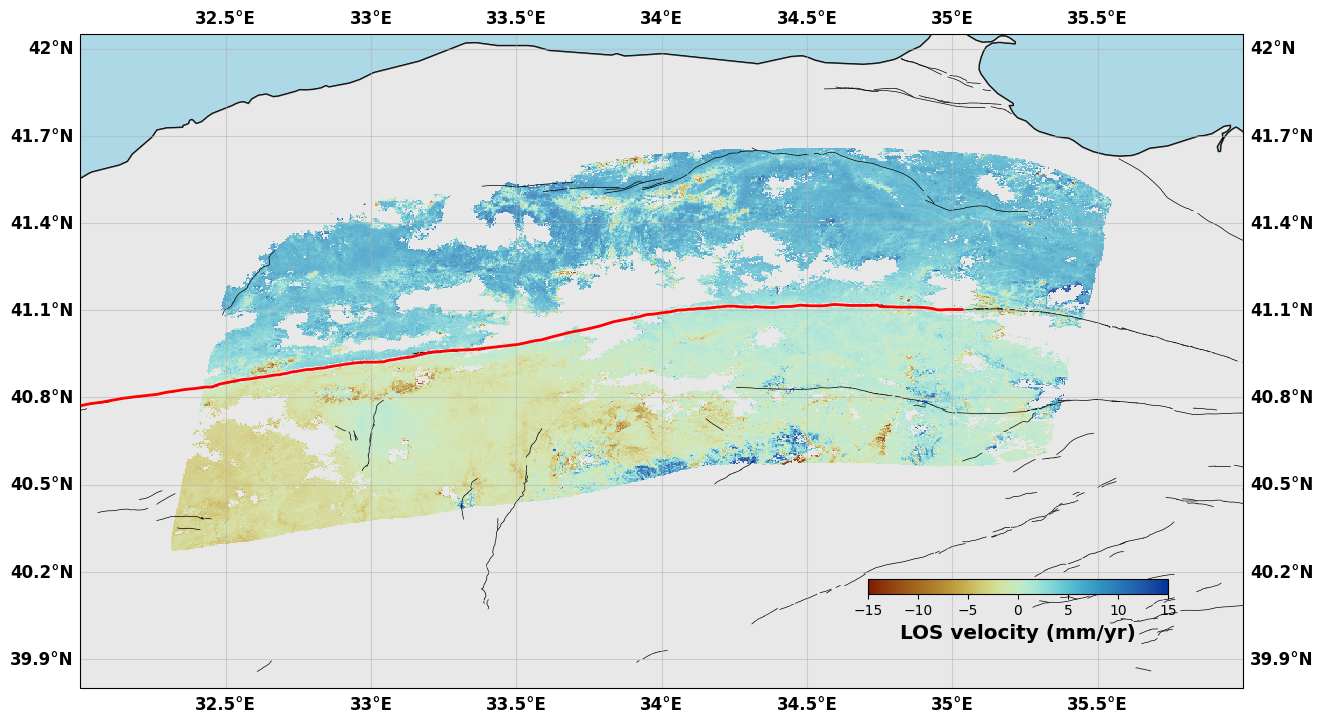

In [8]:
# And we can add faults on top of this map

# Make a figure
rate.plot(plotType='flat',  # Plot style
          norm=[-15, 15],   # Colorbar limits
          figsize=(15, 15), # Figure size
          alpha=0.8,        # Transparency
          box=[32, 36, 39.80, 42.05], # Map extent
          drawCoastlines=True, # Draw coastlines
          faults=naf,       # Add a fault trace
          seacolor='lightblue', # Sea color
          cmap=cm.roma,     # InSAR colormap
          cbaxis=[0.65, 0.34, 0.2, 0.01],  # Colorbar position
          cblabel='LOS velocity (mm/yr)',  # Colorbar label
          show=False,       # Do not show the figure so that we can modify it later
          #shadedtopo={'source': 'srtm', 'smooth': 10, 'alpha': 0.2, 'zorder': 2})    # Shaded topography
)

# Get the correct axis (carte means map in French. Yes, I am French)
ax = rate.fig.carte

# Make a polygon with the four corners of the map (so that we do not plot the faults outside of the map)
# otherwise, it makes a hideous figure with lots of lines outside the axis
# I don't understand why this is not implemented already in the figure object (maybe I am doing something wrong)
poly = [[rate.fig.carte.get_extent()[0], rate.fig.carte.get_extent()[2]], 
        [rate.fig.carte.get_extent()[1], rate.fig.carte.get_extent()[2]],
        [rate.fig.carte.get_extent()[1], rate.fig.carte.get_extent()[3]],
        [rate.fig.carte.get_extent()[0], rate.fig.carte.get_extent()[3]],
        [rate.fig.carte.get_extent()[0], rate.fig.carte.get_extent()[2]]]

# We make it a matplotlib path
area = path.Path([[p[0],p[1]] for p in poly], closed=False)

# We read the fault into segments
fin = open(os.path.join(os.getcwd(),'DataAndModels/AnatoliaFaults.dat'), 'r')
Segments = []
segment = []
NAF = []
for line in fin.readlines():
    if line[0] == '>':
        if segment != []: Segments.append(segment)
        segment = []
    else:
        segment.append((float(line.split()[0]), float(line.split()[1])))

# We plot the fault if it is in the map
for segment in Segments:
    lonf = [s[0] for s in segment]
    latf = [s[1] for s in segment]
    if area.contains_points(np.array(segment)).any():
        ax.plot(lonf, latf, color='k', linewidth=0.5, zorder=1)
        NAF.append(segment)
fin.close()

# Now we want to show the figure but not the fault in 3D that is in the figure object
rate.fig.show(showFig=['map'])

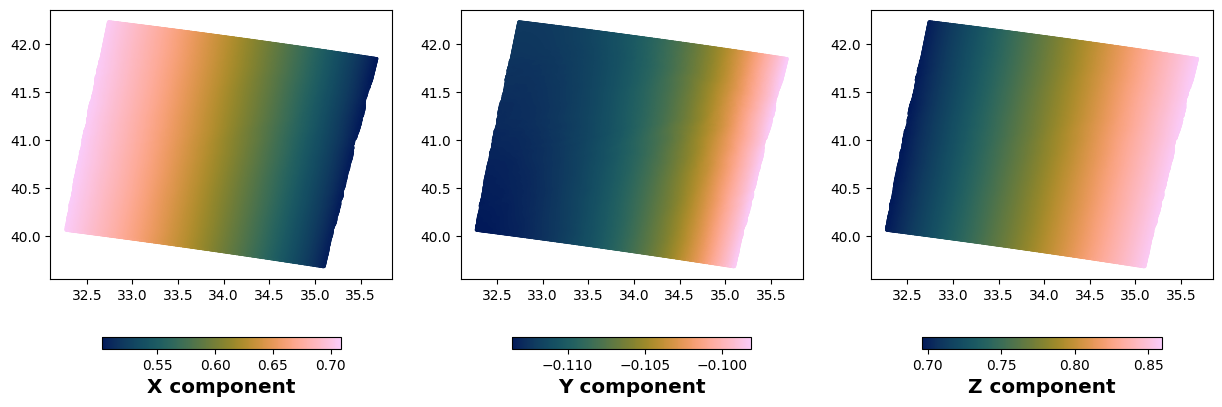

In [9]:
# We can also check the LOS values. The LOS vector is stored in the los attribute of the insar object
fig,axs = plt.subplots(1,3,figsize=(15,5))

# We plot the first component of the LOS vector
gc = axs[0].scatter(rate.lon[::20], rate.lat[::20], c=rate.los[::20,0], s=5., linewidth=0, cmap=cm.batlow)
plt.colorbar(gc, ax=axs[0], shrink=0.7, orientation='horizontal', label='X component')

# We plot the second component of the LOS vector
gc = axs[1].scatter(rate.lon[::20], rate.lat[::20], c=rate.los[::20,1], s=5., linewidth=0, cmap=cm.batlow)
plt.colorbar(gc, ax=axs[1], shrink=0.7, orientation='horizontal', label='Y component')

# We plot the third component of the LOS vector
gc = axs[2].scatter(rate.lon[::20], rate.lat[::20], c=rate.los[::20,2], s=5., linewidth=0, cmap=cm.batlow)
plt.colorbar(gc, ax=axs[2], shrink=0.7, orientation='horizontal', label='Z component')

plt.show()

## Taking profiles across the image


In [10]:
# We do not want to include the NaNs in the downsampling, so we first remove the NaNs from the object.
# Make a velocity object
rate = insar('Rate map T167', lon0=lon0, lat0=lat0)

# Read the binary data into the object
# Note that these arrays could be files
rate.read_from_binary(velocity, lon, lat, err=None, 
                      remove_nan=False, remove_zeros=False, 
                      incidence=inc.flatten(), azimuth=azi.flatten())

# We can keep a copy, just to make sure
allrate = copy.deepcopy(rate)

# Here, we remove the NaNs
rate.checkNaNs()

# Here, we find the points that are more that 60 km away from the fault
d = rate.getDistance2Faults(naf)

# We set these to NaNs
rate.vel[d>60.] = np.nan
rate.vel[d<1.] = np.nan

# And we remove them
rate.checkNaNs()

---------------------------------
---------------------------------
Initialize InSAR data set Rate map T167


In [11]:
# We can make profiles across the data to see what it looks like
rate.getprofile('Creep', 32.8, 40.8, 90., 175., 5.)

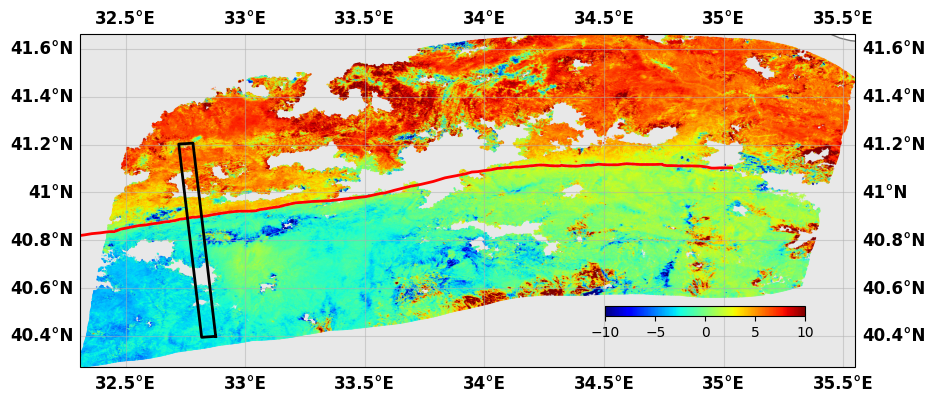

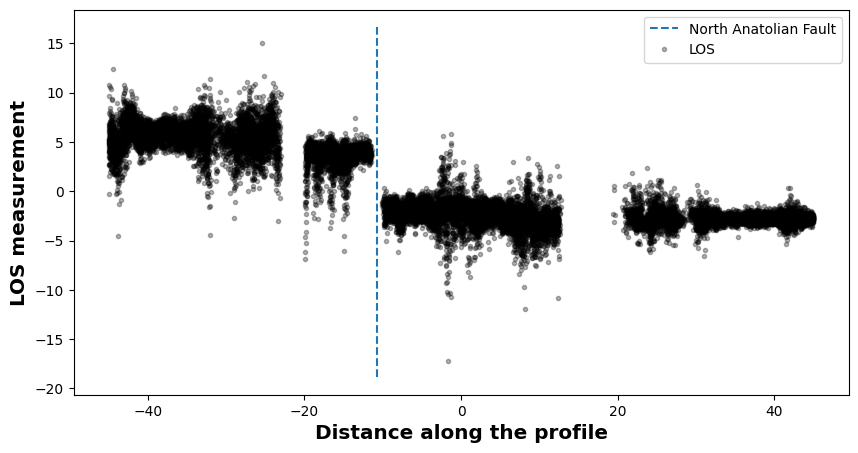

In [12]:
# This shows where the profile is and how it looks like
rate.plotprofile('Creep', norm=(-10,10), cbaxis=[0.65, 0.38, 0.2, 0.01], fault=naf)

In [13]:
# Each profile is stored in a dictionnary in the insar object. Lots of information is stored with it.
print([key for key in rate.profiles['Creep'].keys()])

['Center', 'Length', 'Width', 'Box', 'Lon', 'Lat', 'LOS Velocity', 'LOS Synthetics', 'LOS Error', 'Distance', 'Normal Distance', 'EndPoints', 'EndPointsLL', 'LOS vector']


In [14]:
# If you want to find the intersection of the fault with the profile, you can use the intersectProfile method
# This method is used in the plotting method when you provide the fualt argument (it only uses the fault trace though)
xnaf = rate.intersectProfileFault('Creep', naf)
print(f'The NAF crosses the profile at km {xnaf}')

The NAF crosses the profile at km -10.719261697458444


## Data decimation 

In [15]:
# We do not want to include the NaNs in the downsampling, so we first remove the NaNs from the object.
# Make a velocity object
rate = insar('Rate map T167', lon0=lon0, lat0=lat0)

# Read the binary data into the object
# Note that these arrays could be files
rate.read_from_binary(velocity, lon, lat, err=None, 
                      remove_nan=False, remove_zeros=False, 
                      incidence=inc.flatten(), azimuth=azi.flatten())

# We can keep a copy, just to make sure
allrate = copy.deepcopy(rate)

# Here, we remove the NaNs
rate.checkNaNs()

# Here, we find the points that are more that 60 km away from the fault
d = rate.getDistance2Faults(naf)

# We set these to NaNs
rate.vel[d>60.] = np.nan
rate.vel[d<1.] = np.nan

# And we remove them
rate.checkNaNs()

---------------------------------
---------------------------------
Initialize InSAR data set Rate map T167


In [24]:
# Create the downsampling object
downsampler = imdown('Downsampling {}'.format(rate.name), rate, naf)

# Create an initial state 
# Downsampling window have an initiali size of 15 kilometers
# The minimum downsampling size will be 2 km
# The tolerance is set to 0.08 km
# We do not plot the initial state
downsampler.initialstate(15., 2., tolerance=0.08, plot=False)

# Compute Resolution (Uncomment to have an idea of the threshold)
#downsampler.computeResolution('s', 0.001, vertical=True)
#print('Maximum Resolution: {}'.format(downsampler.Rd.max()))
#print('Minimum Resolution: {}'.format(downsampler.Rd.min()))

# Run the downsampling iterations until Resolution is < threshold
# This approach is described in Lohmann and Simons, 2005
# The quadtree based method is also described in Sudhaus and Jonsson 2009
downsampler.resolutionBased(0.002, 1., slipdirection='d',           # Resolution threshold, minimum downsampling size, slip direction
                            vertical=True, verboseLevel='high',     # Use the vertical displacement in the Green's functions, verbose level
                            plot=False)                # Decimation factor for plotting, plot the results

# Alternatively, run the distance-based downsampling
#downsampler.distanceBased(chardist=2., plot=False, expodist=1.)

# Or the data based downsampling (works well for the case of earthquakes since the displacement is clearly larger than the noise)
#dowsampler.dataBased(0.002)    # This has not been tested for this case

# Reject downsampled pixels that are too close to the fault. These might include data that has been average across the fault
downsampler.newimage.reject_pixels_fault(1., naf)

# We note that the downsampling pattern uses a north-south grid orientation. One could work on changing this to use a more complex downsampling shape.
# One idea would be to use Voronoi cells, but I havent' implemented this yet (as always, be my guest)

---------------------------------
---------------------------------
Initialize InSAR downsampling tools Downsampling Rate map T167
Effective pixel spacing: 0.12614176710505537
---------------------------------
---------------------------------
Downsampling Iterations
Iteration 1: Testing 153 data samples 
 ===> Resolution from 8.398547783462052e-07 to 0.04800860009664166, Mean = 0.0017998034123640387 +- 0.0055843980841027 
Iteration 2: Testing 219 data samples 
 ===> Resolution from 8.039541499305689e-07 to 0.04275711900304684, Mean = 0.004106768462994146 +- 0.007924265376307594 
Iteration 3: Testing 445 data samples 
 ===> Resolution from 7.2054964516758e-07 to 0.15446108148818877, Mean = 0.007437430045122729 +- 0.01409105726990032 
Iteration 4: Testing 1254 data samples 
 ===> Resolution from 0.0 to 0.0016716717085671563, Mean = 5.328954829784081e-05 +- 0.00024036501284647652 
 


array([  70,  115,  129,  132,  253,  404,  510,  645,  748,  749,  831,
        832, 1189])

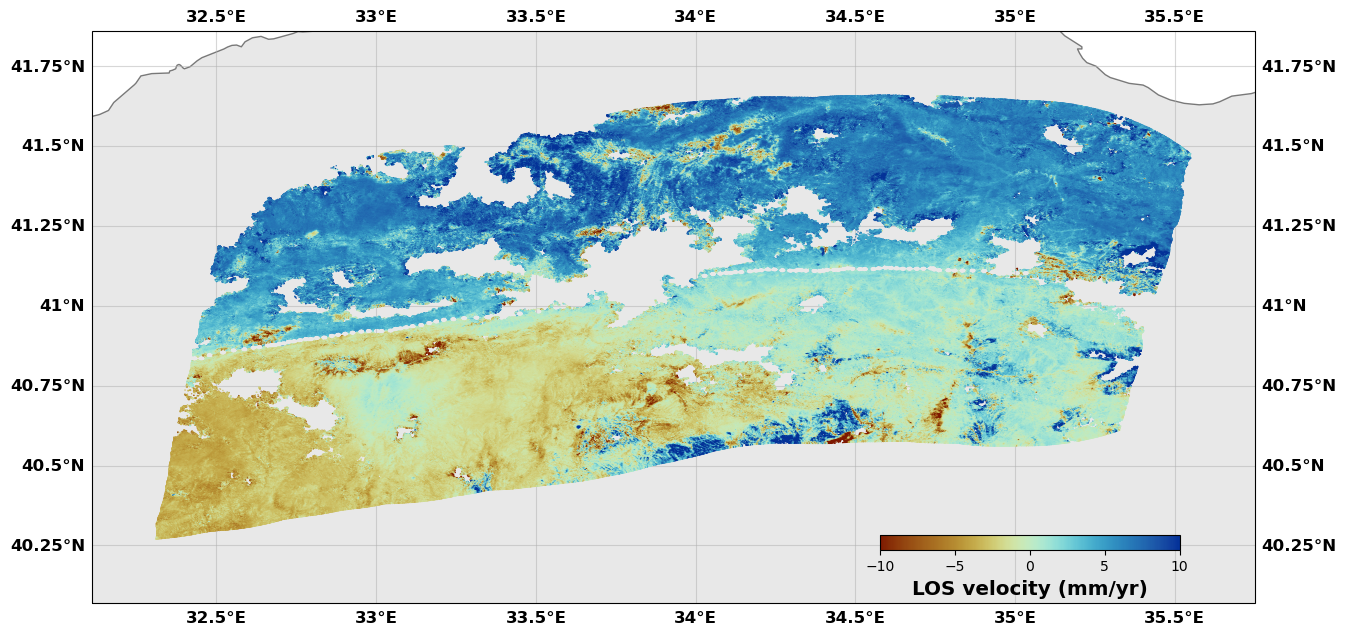

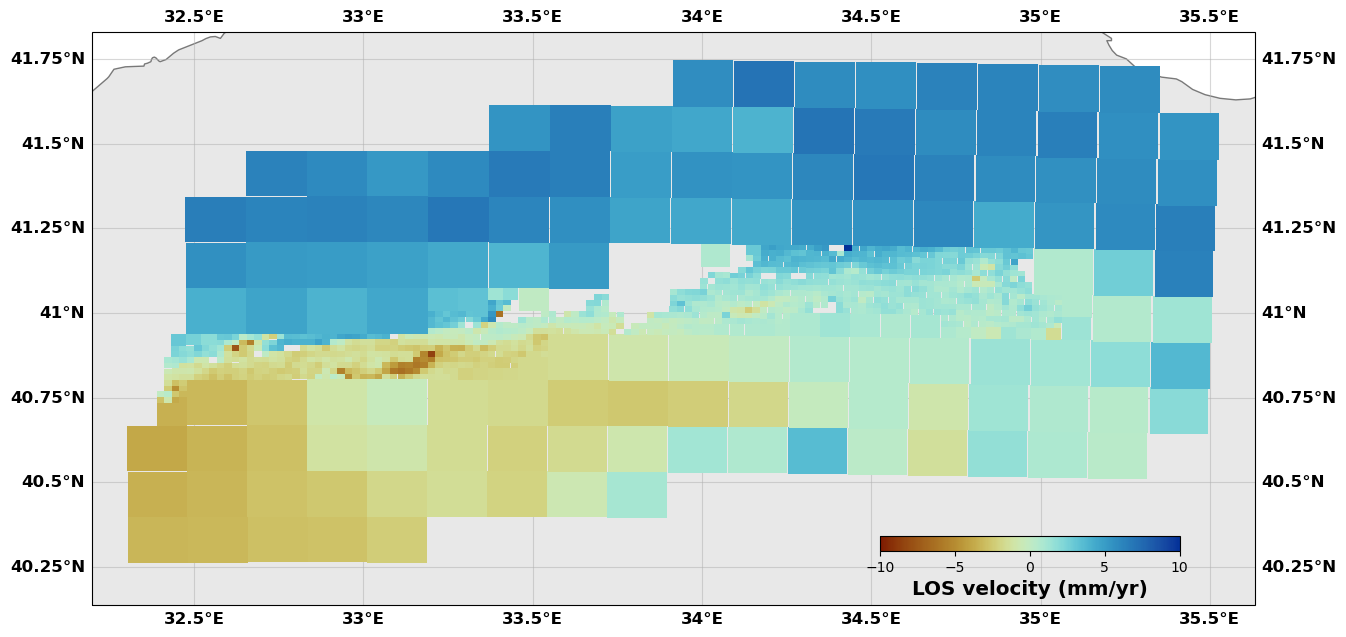

In [25]:
# Show me the results

# The image attribute of the downsampler is the original image (I think it is a pointer to the original rate object)
# The new, downsampled dataset is the attribute newimage. It is also an insar object. It also has an attribute corner which includes the corners of the downsampling boxes.

downsampler.image.plot(plotType='scatter', norm=[-10, 10], figsize=(15,15), 
                       cmap=cm.roma, cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')
downsampler.newimage.plot(plotType='decimate', norm=[-10, 10], figsize=(15,15), edgewidth=0.0, 
                          cmap=cm.roma, cbaxis=[0.65, 0.34, 0.2, 0.01], cblabel='LOS velocity (mm/yr)')

In [26]:
# Take two profiles and plot them to illustrate that we are not losing any information

# On the new image
downsampler.newimage.getprofile('Creep', 32.8, 40.8, 60., 175., 10.)
downsampler.newimage.getprofile('Locked', 34.5, 41., 200., 175., 15.)

# On the original image
downsampler.image.getprofile('Creep', 32.8, 40.8, 60., 175., 10.)
downsampler.image.getprofile('Locked', 34.5, 41., 200., 175., 10.)

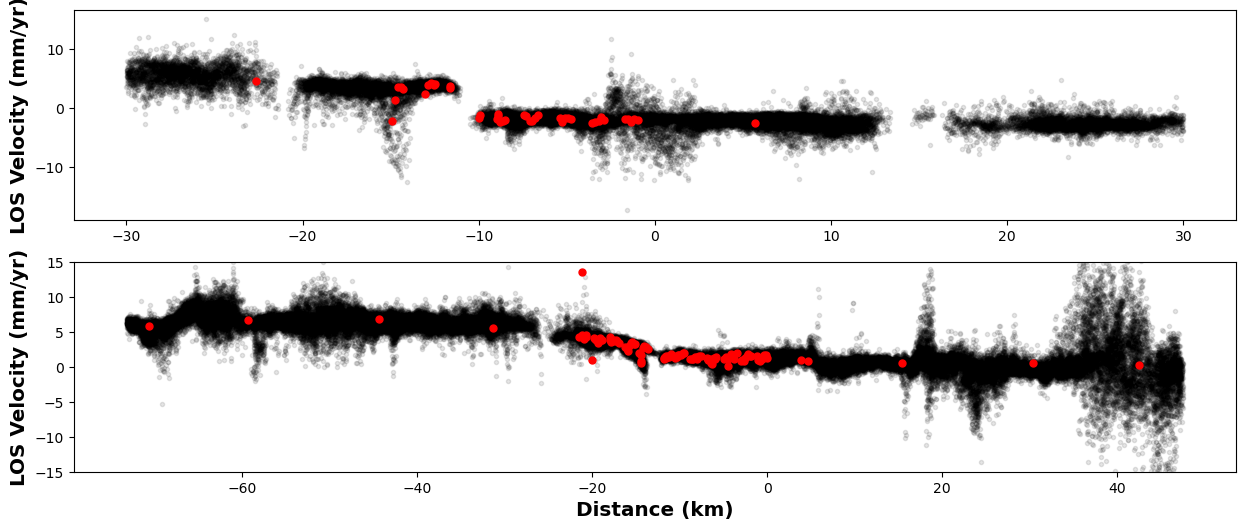

In [27]:
# Show them
fig, axs = plt.subplots(2,1,figsize=(15, 6))

# First profile
ax = axs[0]
profile = downsampler.image.profiles['Creep']
ax.plot(profile['Distance'], profile['LOS Velocity'], '.k', alpha=0.1)
profile = downsampler.newimage.profiles['Creep']
ax.plot(profile['Distance'], profile['LOS Velocity'], '.r', markersize=10)
ax.set_ylabel('LOS Velocity (mm/yr)')

# Second one
ax = axs[1]
profile = downsampler.image.profiles['Locked']
ax.plot(profile['Distance'], profile['LOS Velocity'], '.k', alpha=0.1)
profile = downsampler.newimage.profiles['Locked']
ax.plot(profile['Distance'], profile['LOS Velocity'], '.r', markersize=10)
ax.set_ylim([-15, 15])
ax.set_ylabel('LOS Velocity (mm/yr)')
ax.set_xlabel('Distance (km)')

# Show me
plt.show()

In [28]:
# Of course all of this downsampling can be written down in two output files
# The file name is just the main name of the files. The file name will be with '.txt' extension. 
# If rsp is True, then an additional file is written with the decimation pattern (the corners of the boxes). It has a '.rsp' extension.

# Uncomment to run
#downsampler.writeDownsampled2File('{}'.format(rate.name), rsp=True)

## Covariance computing

In [29]:
# We do not want to include the NaNs in the covariance calculation, so we first remove the NaNs from the object.
# Make a velocity object
rate = insar('Rate map T167', lon0=lon0, lat0=lat0)

# Read the binary data into the object
# Note that these arrays could be files
rate.read_from_binary(velocity, lon, lat, err=None, 
                      remove_nan=False, remove_zeros=False, 
                      incidence=inc.flatten(), azimuth=azi.flatten())

# Here, we remove the NaNs
rate.checkNaNs()

# Here, we find the points that are more that 60 km away from the fault
d = rate.getDistance2Faults(naf)

# We set these to NaNs
rate.vel[d>60.] = np.nan
rate.vel[d<1.] = np.nan

# And we remove them
rate.checkNaNs()

---------------------------------
---------------------------------
Initialize InSAR data set Rate map T167


In [30]:
# Create the covariance object
covariance = imcov('Rate map T167', rate, verbose=True)

# Keep only where we want to compute the covariance
# There is also a maskOut method that kicks out a region if needed
covariance.maskIn([33.5, 34.5, 39.9, 40.7])

# Compute the covariance
# frac is the fraction of the image used to compute the covariance (an integer number will give you a fixed number of couple of points while a float < 1 will give you a fraction of the 
# total number of couple of points)
# every is the binning distance used to compute the covariance
# distmax is the max distance used to compute the covariance
# rampEst allows to estimate a ramp before computing the covariance
covariance.computeCovariance(frac=20000, every=0.25, distmax=20., rampEst=True)
#covariance.computeCovariance(frac=1.0)

# Write to files. Uncomment to run
# covariance.write2file()

---------------------------------
---------------------------------
Initialize InSAR covariance tools Rate map T167
Dealing with data set Rate map T167
     Zone of Interest: 33.5 <= Lon <= 34.5 || 39.9 <= Lat <= 40.7
Computing covariograms
Computing 1-D empirical semivariogram function for data set Rate map T167
Selecting 20000 random samples to estimate the covariance function
Estimated Orbital Plane: -0.004880685666717254xy + 22.029343958335733x + 2.577465516264471y + -11637.782444608603
Build the permutations
Digitize the histogram
Fitting Covariance functions
Dataset Rate map T167:
A prior values: Sill | Sigma | Lambda
                 2.392189 | 0.899980 | 2.466839
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.07692809281218188
            Iterations: 60
            Function evaluations: 361
            Gradient evaluations: 60
Dataset Rate map T167:
     Sill   :  2.3766038647897205
     Sigma  :  1.3796431223895675
     Lambda :  5.

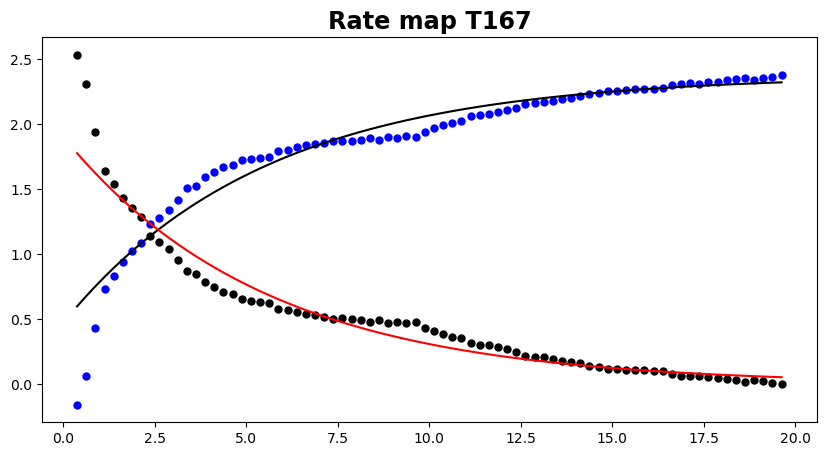

In [31]:
# Show me the covariance
covariance.plot(data='all')

In [32]:
# As you can see, there is some possible additional work to be done here as the shape of the covariance is not always a simple 
# exponential decay. We have added the possibility to use a gaussian covariance, but this results in non-definite matrices.
# Some work is required here...